# Explore the store item demand dataset and the opsd dataset

In [4]:
import acquire
import prepare
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# plotting defaults
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)


In [5]:
store = acquire.acquire_all()

In [6]:
store = prepare.prepare_store(store)

In [9]:
store.index.min()

Timestamp('2013-01-01 00:00:00')

In [10]:
store.index.max()

Timestamp('2017-12-31 00:00:00')

In [11]:
store.index.max()-store.index.min()

Timedelta('1825 days 00:00:00')

Store dataset contains data from 2013 - end of 2017, 5 years. Will split train as first 4 years and test as last year

In [14]:
train = store.loc[:'2016']
test = store.loc['2017']

In [26]:
train.columns

Index(['item', 'quantity', 'sale_id', 'store', 'item_brand', 'item_id',
       'item_name', 'item_price', 'item_upc12', 'item_upc14', 'store_address',
       'store_city', 'store_id', 'store_state', 'store_zipcode', 'month',
       'day_of_week', 'sales_total'],
      dtype='object')

Change day of week to ordered categorical for better plotting

In [91]:
train['day_of_week'] = train.index.strftime('%a')

train['day_of_week'] = pd.Categorical(train.day_of_week,categories=['Sun','Mon','Tue','Wed','Thu','Fri','Sat'],ordered=True)

Bin item prices

In [186]:
train['price_bin']=pd.qcut(train.item_price, 4, labels=['cheap','low','mid','expensive'])

In [197]:
# Attempt to bin items into categories such as breakfast, toiletries, etc.

In [196]:
[item for item in train.item_name.unique() if 'cereal' in item.lower()]

['Kelloggs Disney Pixar Cars 2 Cereal',
 'Bear Naked Fit Almond Crisp 100 Percent Natural Energy Cereal',
 'Moms Best Naturals Cereal Toasted Cinnamon Squares']

## Exploration questions
- Target Variable is sales_total
1. How does the sales_total change throughout the year for all stores?
    - Are there seasonal tendencies?
    - Same for all stores?
2. Do any days of the week exhibit higher sales than others?
3. Do the stores follow the same sales pattern or do some sell more of one product than another?
4. Do the quantities of every item follow a seasonal tendency?

Text(0.5, 0.98, 'Sales Total Frequency by Store - Most Stores Follow a Normal Distribution')

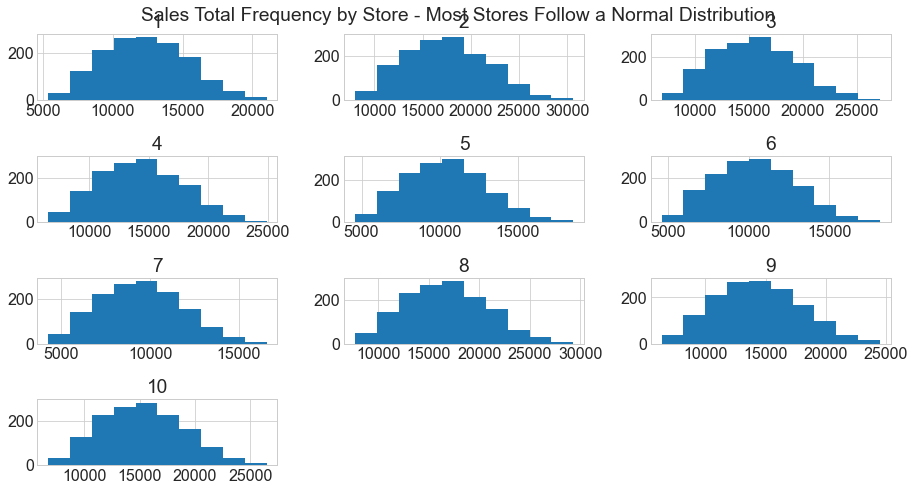

In [73]:
train.groupby(['store',train.index.date]).sales_total.sum().unstack(level=0).hist()
plt.tight_layout()
plt.suptitle('Sales Total Frequency by Store - Most Stores Follow a Normal Distribution')

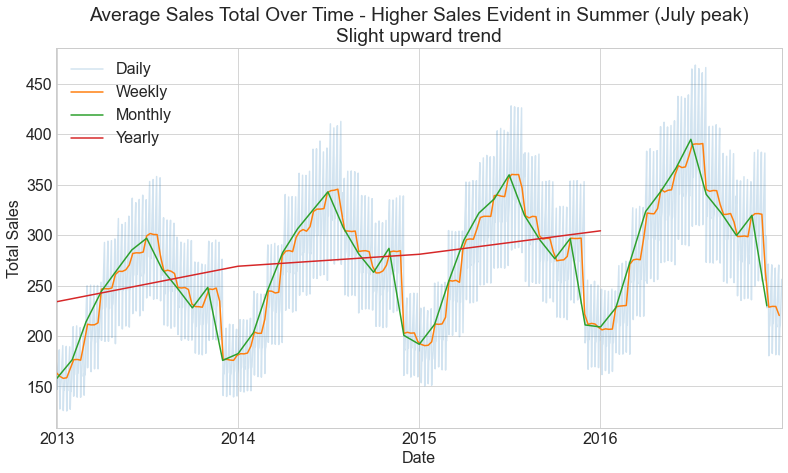

In [120]:
train.resample('D').sales_total.mean().plot(alpha=0.2,label='Daily')
train.resample('W').sales_total.mean().plot(label='Weekly')
train.resample('M').sales_total.mean().plot(label='Monthly')
train.resample('Y').sales_total.mean().plot(label='Yearly')
plt.title('Average Sales Total Over Time - Higher Sales Evident in Summer (July peak)\nSlight upward trend')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()

Text(0, 0.5, 'Total Sales')

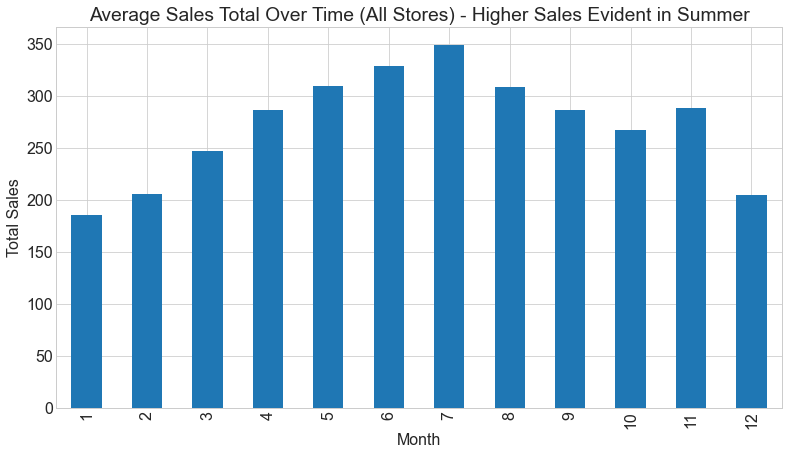

In [81]:
train.groupby(train.index.month).sales_total.agg('mean').plot.bar()
plt.title('Average Sales Total Over Time (All Stores) - Higher Sales Evident in Summer')
plt.xlabel('Month')
plt.ylabel('Total Sales')

Text(0.5, 1.0, 'Weekly Total Sales by Store - All Stores Follow Similar Seasonal Pattern\nSome stores do more business than others')

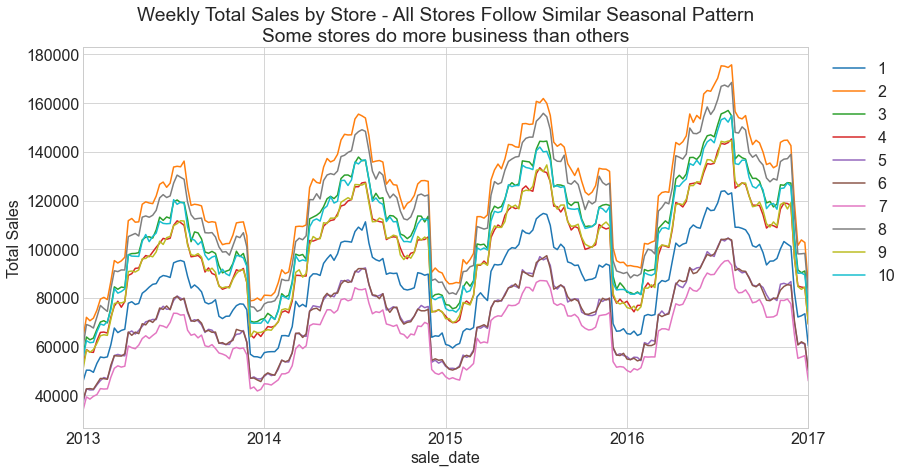

In [56]:
train.groupby('store').resample('W').sales_total.sum().unstack(level=0).plot()
plt.legend(loc="upper right", bbox_to_anchor=(1.14, 1),)
plt.ylabel('Total Sales')
plt.title('Weekly Total Sales by Store - All Stores Follow Similar Seasonal Pattern\nSome stores do more business than others')

### Day of the week - any more sales than others?

Text(0, 0.5, 'Average Sales Total')

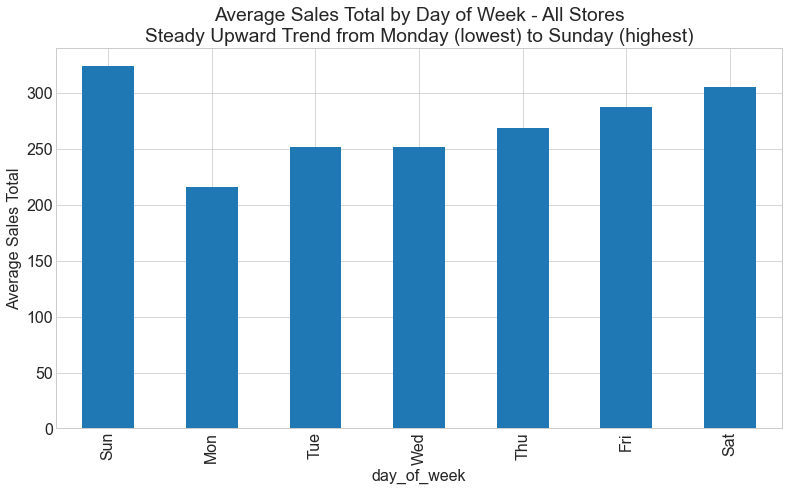

In [98]:
train.groupby(train.day_of_week).sales_total.agg('mean').plot.bar()
plt.title('Average Sales Total by Day of Week - All Stores\nSteady Upward Trend from Monday (lowest) to Sunday (highest)')
plt.ylabel('Average Sales Total')

<AxesSubplot:xlabel='day_of_week', ylabel='sales_total'>

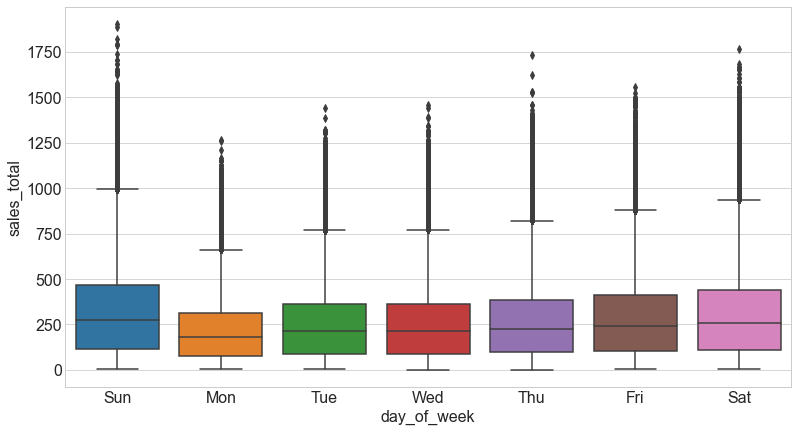

In [107]:
sns.boxplot(data = train, x='day_of_week', y = 'sales_total')

### Visualize change over time

<AxesSubplot:title={'center':'Average Week To Week Change in Total Sales'}, xlabel='sale_date'>

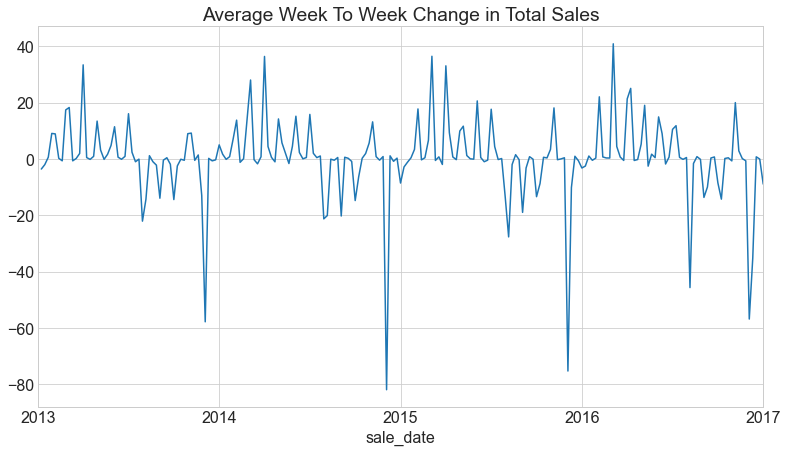

In [125]:
train.resample('W').sales_total.mean().diff().plot(title='Average Week To Week Change in Total Sales')

<AxesSubplot:title={'center':'Average Month to Month Change in Total Sales'}, xlabel='sale_date'>

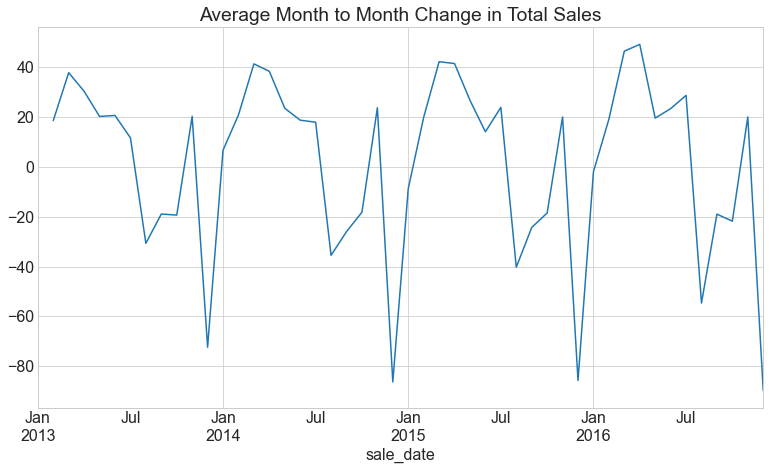

In [126]:
train.resample('M').sales_total.mean().diff().plot(title='Average Month to Month Change in Total Sales')

### Seasonal plot

<AxesSubplot:title={'center':'Seasonal Plot - Sales Rise Year to Year'}, xlabel='sale_date'>

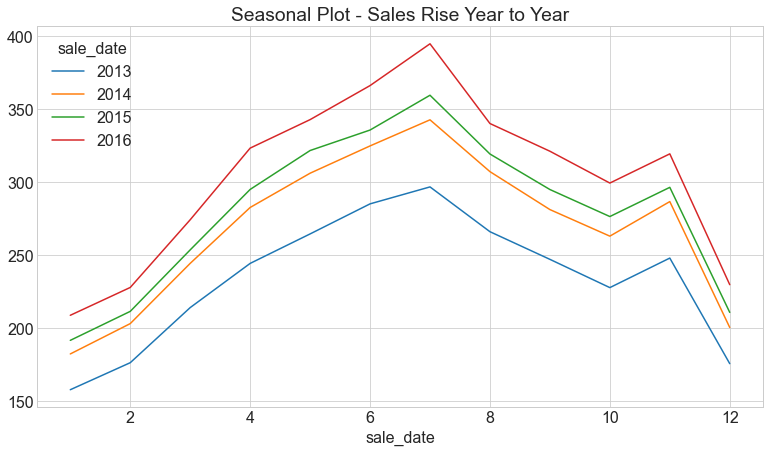

In [130]:
# .unstack turns an index level into columns
train.groupby([train.index.year, train.index.month]).sales_total.mean().unstack(0).plot(title='Seasonal Plot - Sales Rise Year to Year')


### Seasonal subseries

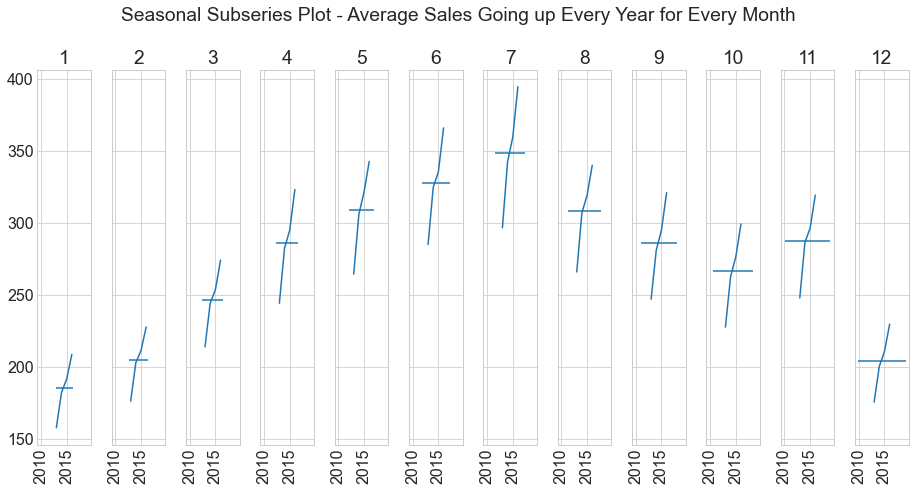

In [133]:
table = train.groupby([train.index.year, train.index.month]).sales_total.mean().unstack()

fig, axs = plt.subplots(1, 12, sharey=True, sharex=True)
for ax, (month, subset) in zip(axs, table.iteritems()):
    subset.plot(ax=ax, title=month)
    ax.hlines(subset.mean(), *ax.get_xlim())
    ax.set(xlabel='')
    ax.tick_params('x',rotation=90)

fig.suptitle('Seasonal Subseries Plot - Average Sales Going up Every Year for Every Month') # super-title for the overall figure
fig.subplots_adjust(wspace=0)
fig.tight_layout()


### Lag Plot

Text(0.5, 1.0, 'Daily Lag Plot - Multiple Separate Linear Relationships Apparent')

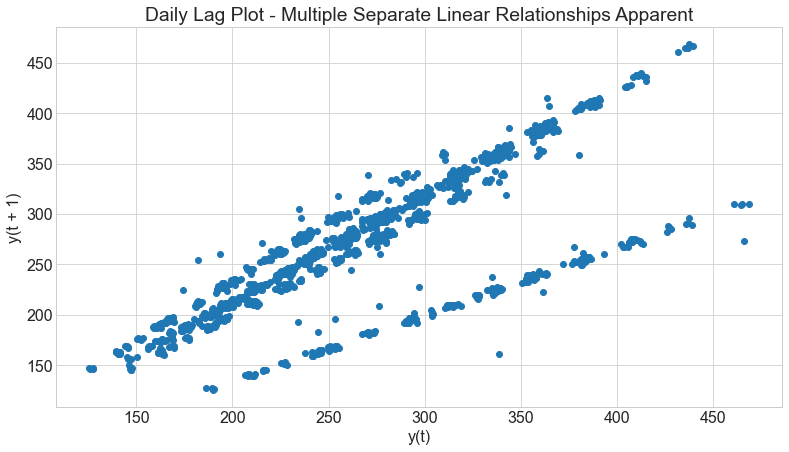

In [142]:
pd.plotting.lag_plot(train.sales_total.resample('D').mean(), lag=1)
plt.title('Daily Lag Plot - Multiple Separate Linear Relationships Apparent')

Text(0.5, 1.0, 'Weekly Lag Plot - Fairly Linear Relationship')

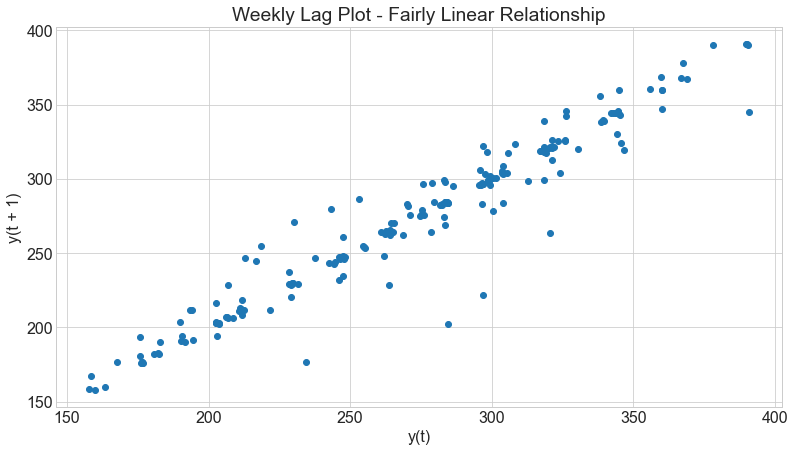

In [144]:
pd.plotting.lag_plot(train.sales_total.resample('W').mean(), lag=1)
plt.title('Weekly Lag Plot - Fairly Linear Relationship')

### Autocorrelation Plot

Text(0.5, 1.0, 'Definite correlation from year to year - strongest from previous year')

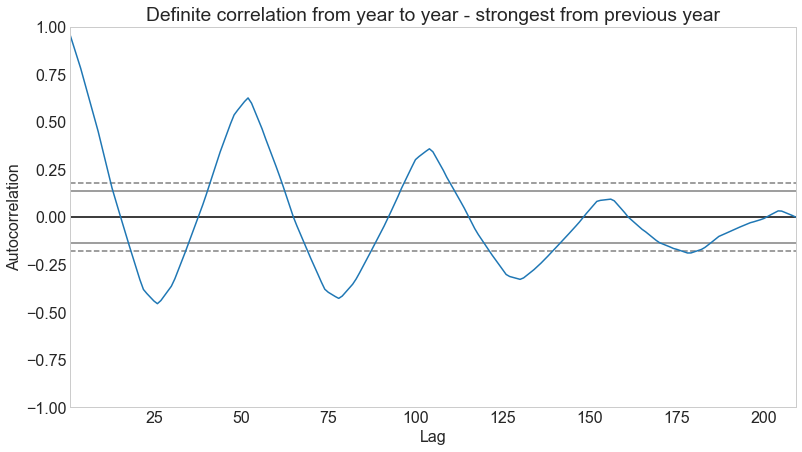

In [147]:
pd.plotting.autocorrelation_plot(train.sales_total.resample('W').mean())
plt.title('Definite correlation from year to year - strongest from previous year')

### Seasonal Decomposition

<AxesSubplot:xlabel='sale_date'>

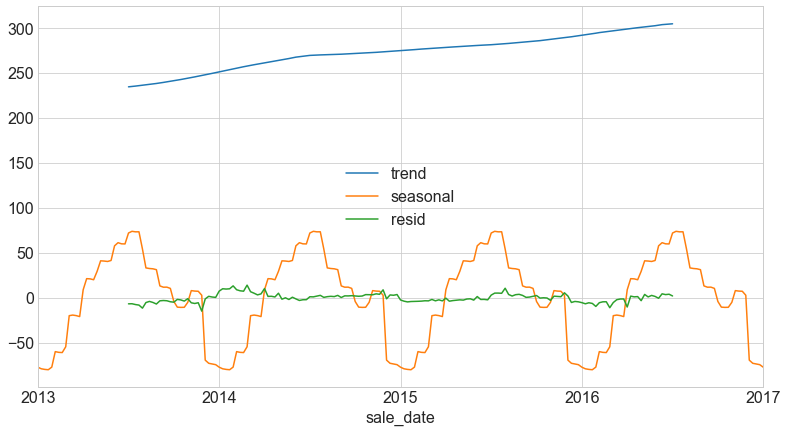

In [156]:
y = train.sales_total.resample('W').mean()

result = sm.tsa.seasonal_decompose(y)
decomposition = pd.DataFrame({
    'y': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal,
    'resid': result.resid,
})
decomposition.iloc[:,1:].plot()

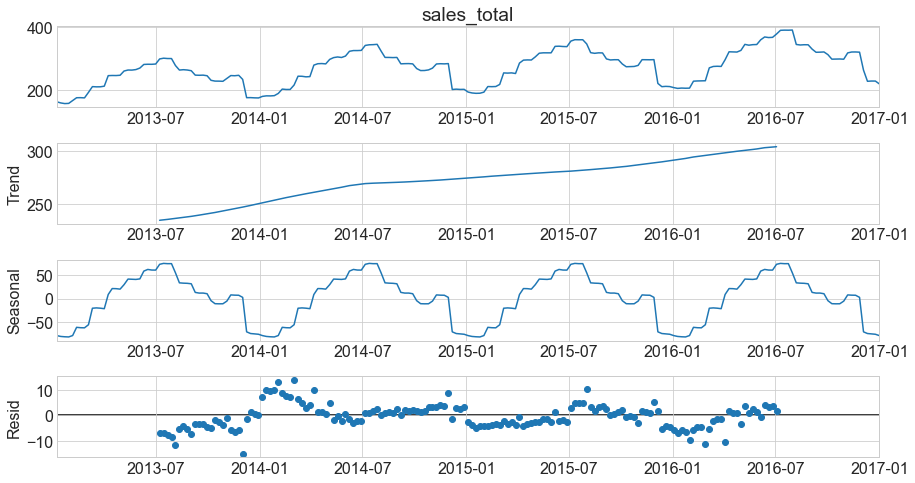

In [155]:
result.plot()
None

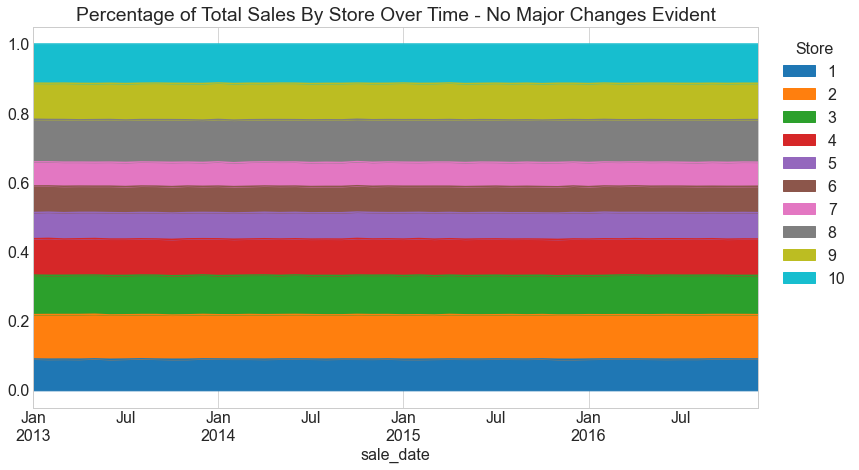

In [176]:
train.groupby('store').resample('M').sales_total.sum().unstack(0).apply(lambda row: row / row.sum(), axis=1).plot.area()
plt.title('Percentage of Total Sales By Store Over Time - No Major Changes Evident')
plt.legend(loc="upper right", bbox_to_anchor=(1.14, 1),title='Store')

In [198]:
power = acquire.acquire_power_data()

In [199]:
power = prepare.prepare_power(power)

In [202]:
power.head()

,date,consumption,wind,solar,wind_solar,month,year
Date,,,,,,,
2006-01-01,2006-01-01,1069.184,0.0,0.0,0.0,1,2006
2006-01-02,2006-01-02,1380.521,0.0,0.0,0.0,1,2006
2006-01-03,2006-01-03,1442.533,0.0,0.0,0.0,1,2006
2006-01-04,2006-01-04,1457.217,0.0,0.0,0.0,1,2006
2006-01-05,2006-01-05,1477.131,0.0,0.0,0.0,1,2006


Split data:
- Many years of data but only 2010 onward has wind/solar data so will split so train up to end of 2015 and test 2016 and beyond

In [206]:
train = power.loc[:'2015']
test = power.loc['2016':]

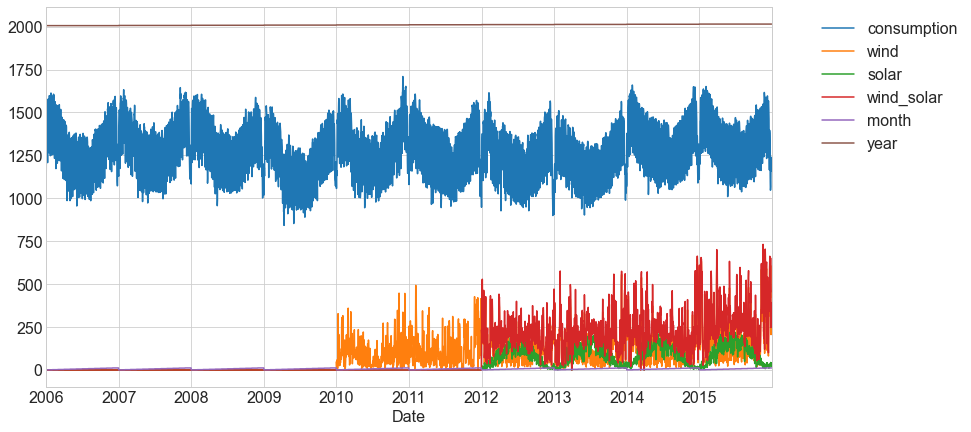

In [215]:
train.plot()
plt.legend(loc="best", bbox_to_anchor=(1.05, 1))

In [263]:
# store target (consumption) in variable y
y = train.consumption

<AxesSubplot:ylabel='Frequency'>

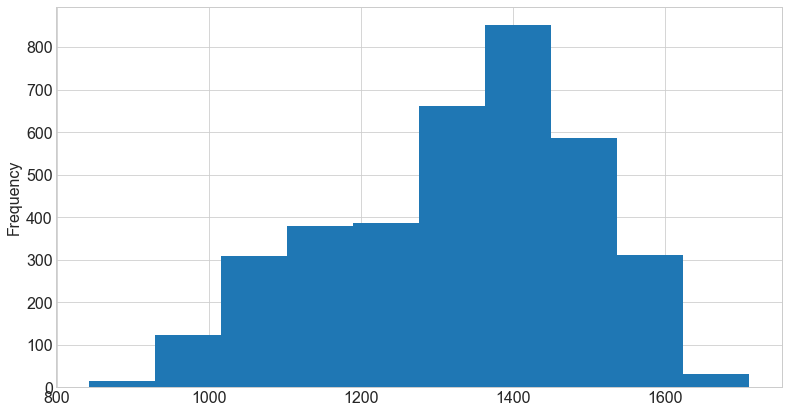

In [264]:
y.plot.hist()

[Text(0.5, 1.0, 'Average Consumption by Month - Higher Values in Winter'),
 Text(0.5, 0, 'Month'),
 Text(0, 0.5, 'Consumption')]

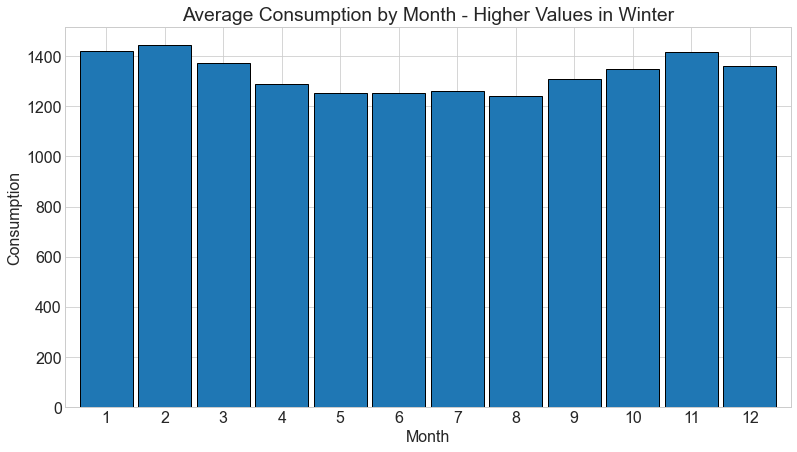

In [265]:
ax = y.groupby(y.index.month).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Consumption by Month - Higher Values in Winter', xlabel='Month', ylabel='Consumption')


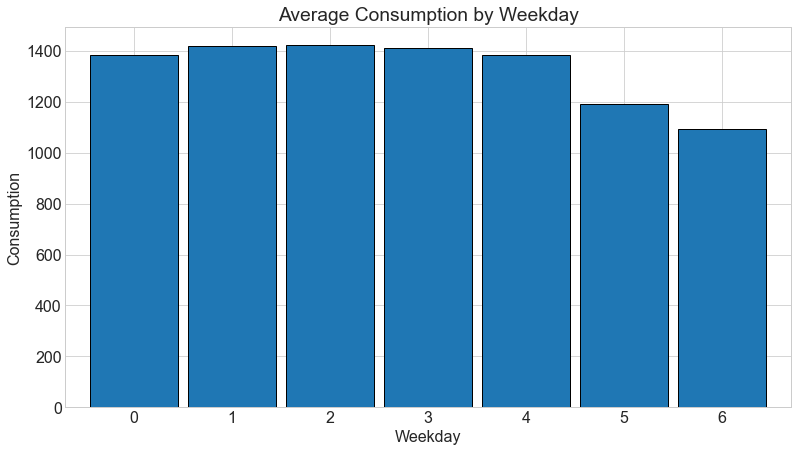

In [266]:
y.groupby(y.index.day_of_week).mean().plot.bar(width=.9, ec='black',title='Average Consumption by Weekday', xlabel='Weekday', ylabel='Consumption')
plt.xticks(rotation=0)
plt.show()



In [267]:
train["day_name"] = train.index.day_name()

<AxesSubplot:xlabel='day_name', ylabel='consumption'>

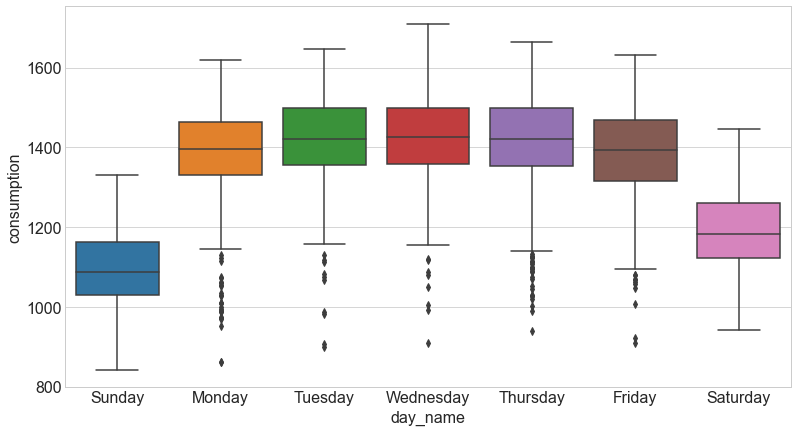

In [268]:
sns.boxplot(data = train, x = 'day_name', y = 'consumption')

Clearly much more consumption during week compared to weekend

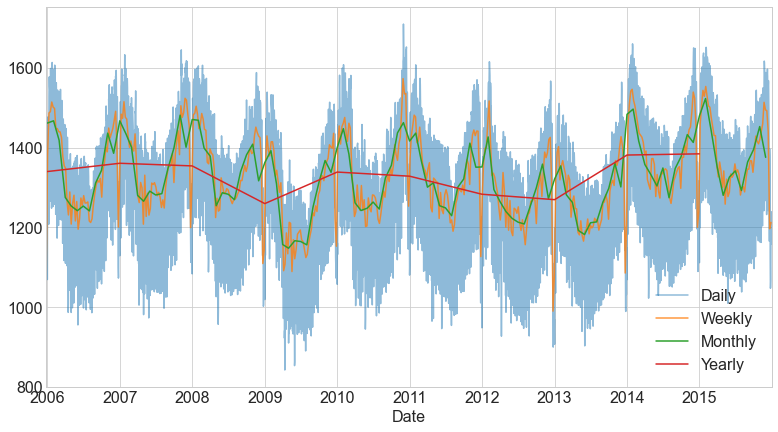

In [274]:
y.plot(alpha=.5, label='Daily')
y.resample('W').mean().plot(alpha=.8, label='Weekly')
y.resample('M').mean().plot(label='Monthly')
y.resample('Y').mean().plot(label='Yearly')
plt.legend()


<AxesSubplot:title={'center':'Average week-to-week change in consumption'}, xlabel='Date'>

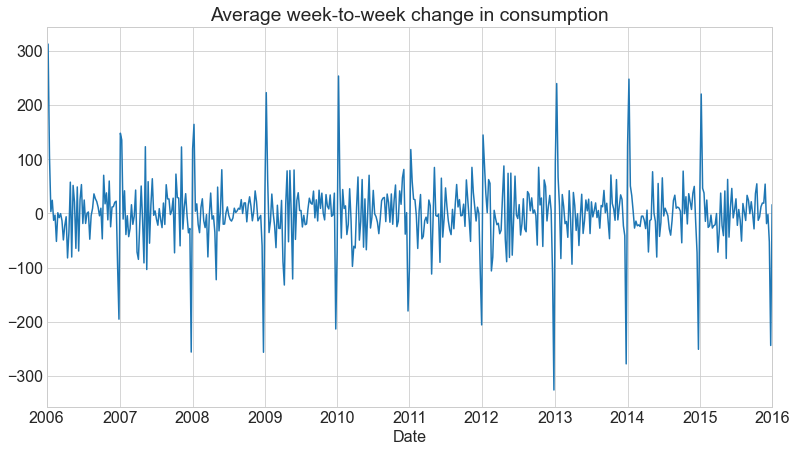

In [275]:
y.resample('W').mean().diff().plot(title='Average week-to-week change in consumption')

<AxesSubplot:title={'center':'Average month-to-month change in consumption'}, xlabel='Date'>

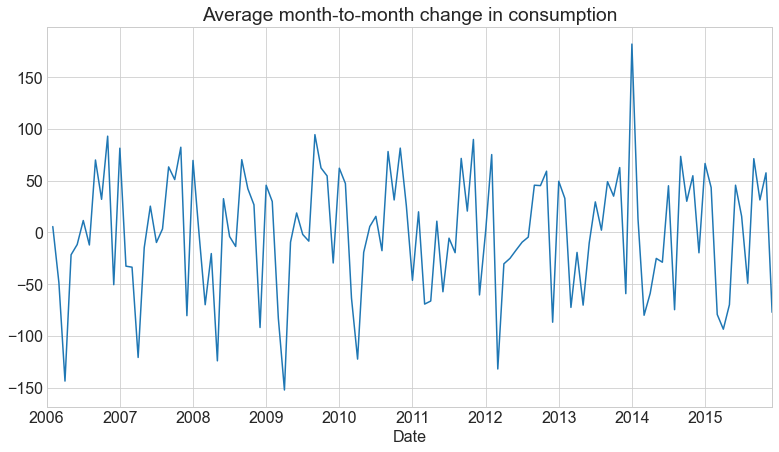

In [276]:
y.resample('M').mean().diff().plot(title='Average month-to-month change in consumption')

Text(0, 0.5, 'Average consumption')

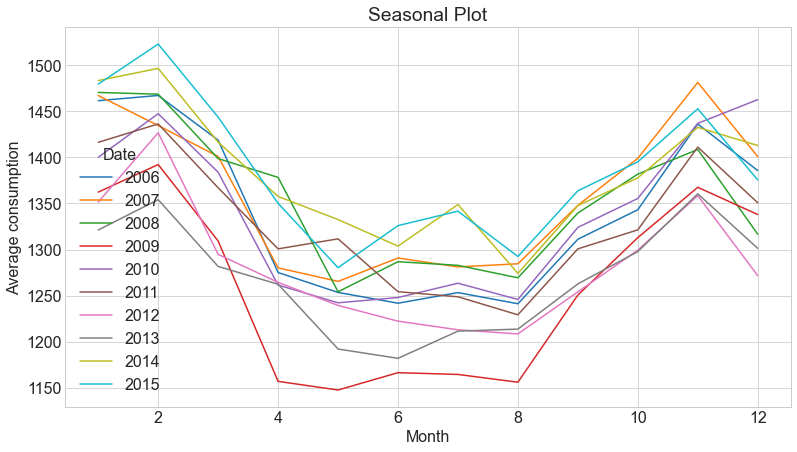

In [279]:
# .unstack turns an index level into columns
y.groupby([y.index.year, y.index.month]).mean().unstack(0).plot(title='Seasonal Plot')
plt.xlabel('Month')
plt.ylabel('Average consumption')

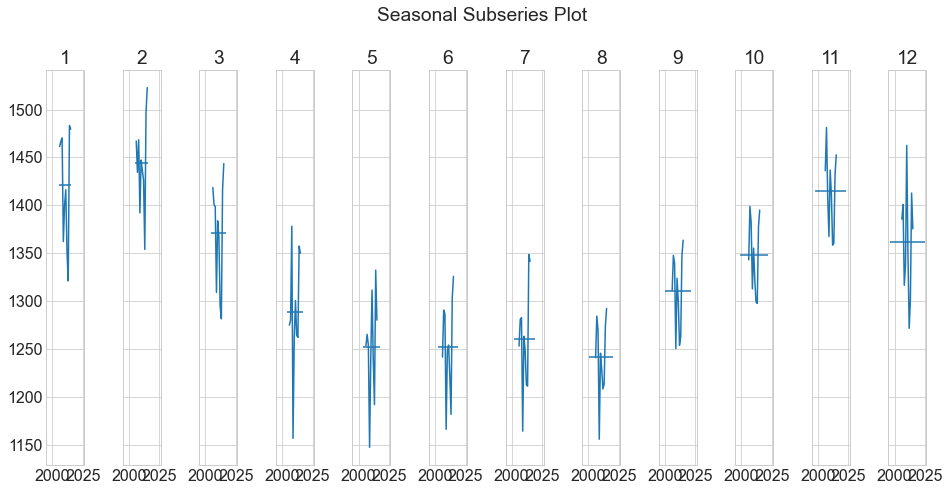

In [287]:
table = y.groupby([y.index.year, y.index.month]).mean().unstack()

fig, axs = plt.subplots(1, 12, sharey=True, sharex=True)
for ax, (month, subset) in zip(axs, table.iteritems()):
    subset.plot(ax=ax, title=month)
    ax.hlines(subset.mean(), *ax.get_xlim())
    ax.set(xlabel='')

fig.suptitle('Seasonal Subseries Plot') # super-title for the overall figure
fig.subplots_adjust(wspace=-2)
fig.tight_layout()

Text(0.5, 1.0, 'Half Year Lag Plot - No Correlation Observed')

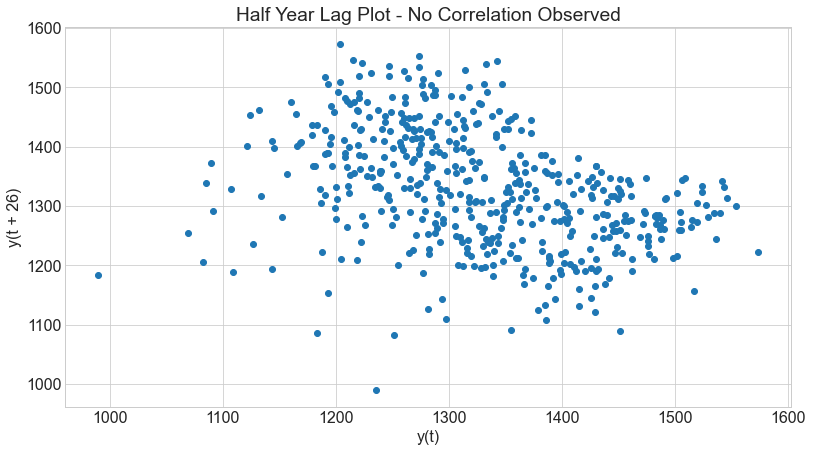

In [290]:
pd.plotting.lag_plot(train.consumption.resample('W').mean(), lag=26)
plt.title('Half Year Lag Plot - No Correlation Observed')

Text(0.5, 1.0, '1 Week Lag Plot - Linear Correlation Observed')

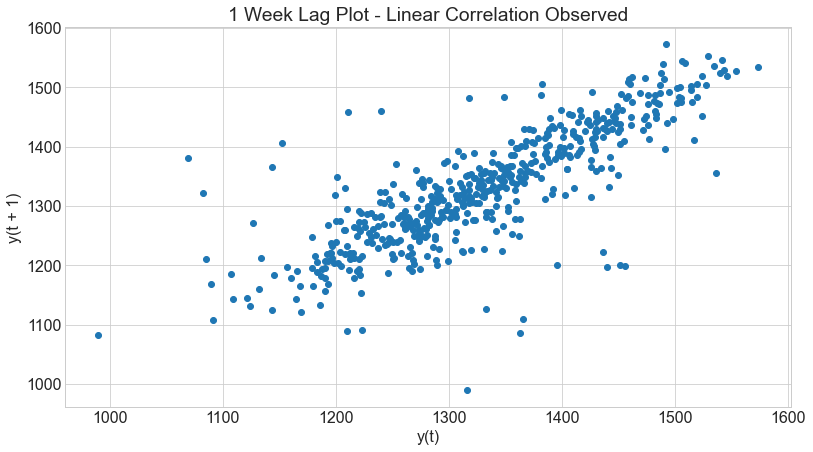

In [292]:
pd.plotting.lag_plot(train.consumption.resample('W').mean(), lag=1)
plt.title('1 Week Lag Plot - Linear Correlation Observed')

Text(0.5, 1.0, '1 Day Lag Plot - Multiple Linear Correlations Observed')

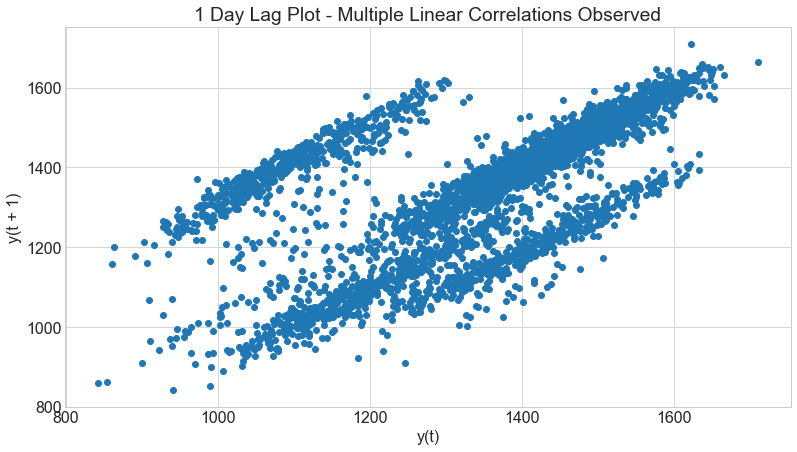

In [295]:
pd.plotting.lag_plot(train.consumption.resample('D').mean(), lag=1)
plt.title('1 Day Lag Plot - Multiple Linear Correlations Observed')

Text(0.5, 1.0, 'Mean Consumption Weekly Autocorrelation\nConsistent Seasonal Autocorrelation Observed Out to 4 Years')

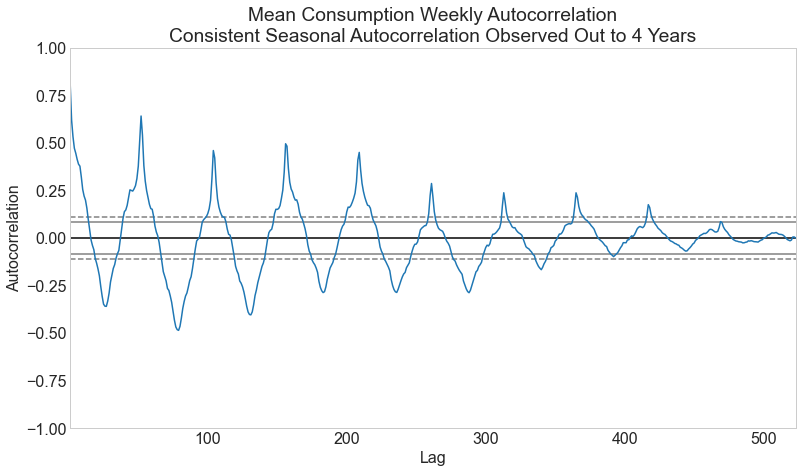

In [302]:
pd.plotting.autocorrelation_plot(train.consumption.resample('W').mean())
plt.title('Mean Consumption Weekly Autocorrelation\nConsistent Seasonal Autocorrelation Observed Out to 4 Years')

<AxesSubplot:xlabel='Date'>

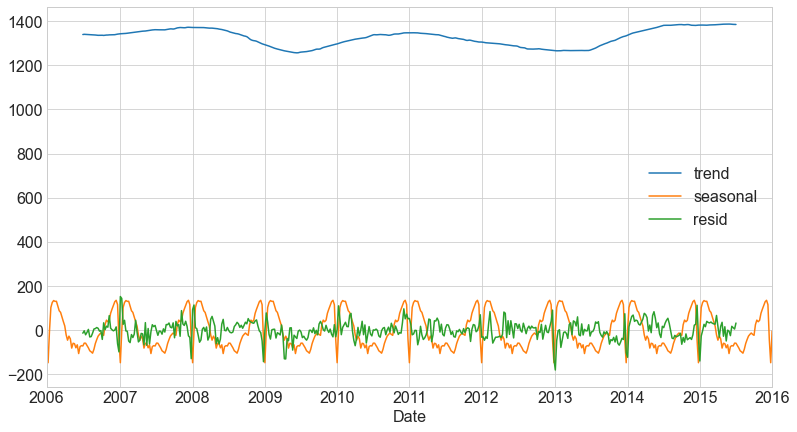

In [303]:
y = train.consumption.resample('W').mean()

result = sm.tsa.seasonal_decompose(y)
decomposition = pd.DataFrame({
    'y': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal,
    'resid': result.resid,
})
decomposition.iloc[:, 1:].plot()


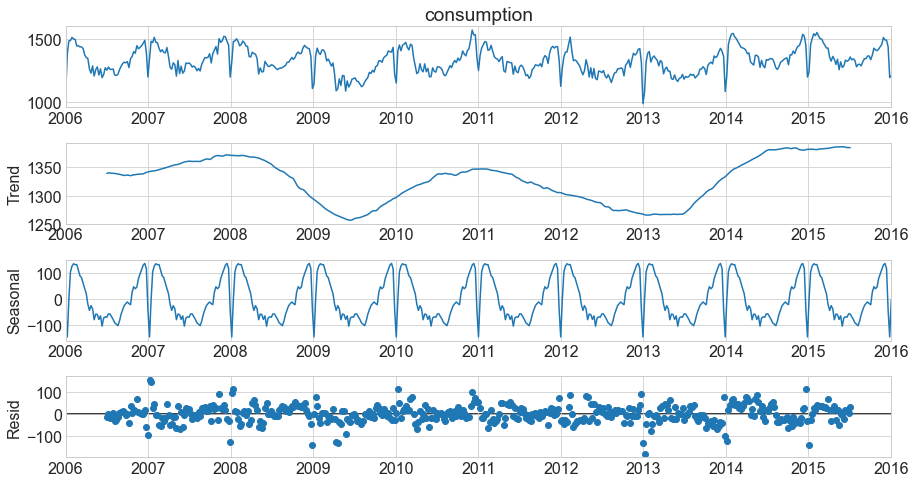

In [304]:
# the value returned from seasonal_decompose can itself be plotted:
result.plot()
None


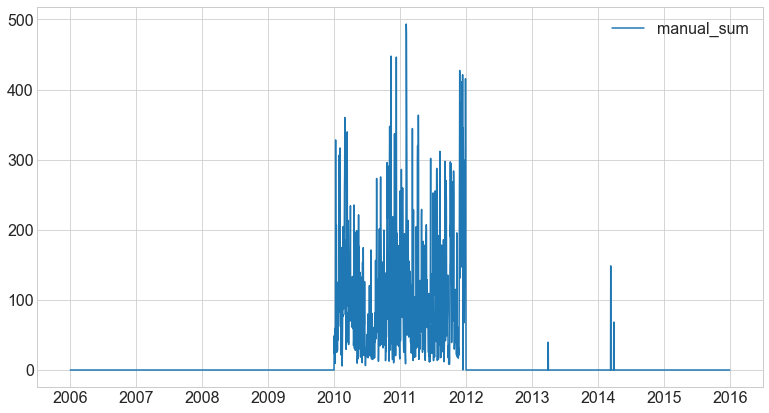

In [312]:
# plt.plot(train.wind_solar, label='wind_solar')
plt.plot((train.wind+train.solar)-train.wind_solar, label='manual_sum')
plt.legend()